In [ ]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import cv2
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential, Model
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.mobilenet import MobileNet
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import decode_predictions
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor
from keras.applications.xception import Xception
from keras.applications import resnet
from keras.layers import Dropout, GlobalAveragePooling2D, Dense, Dropout, Flatten
import matplotlib.pyplot as plt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
#%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
PATH = os.path.abspath(os.path.join('..', 'input/sample/'))
SOURCE_IMAGES = os.path.join(PATH, "sample", "images")
images = glob(os.path.join("/gdrive/My Drive/multi_class/sample/sample/images", "*.png"))

images[0:10]

['/gdrive/My Drive/multi_class/sample/sample/images/00023173_003.png',
 '/gdrive/My Drive/multi_class/sample/sample/images/00002608_001.png',
 '/gdrive/My Drive/multi_class/sample/sample/images/00015058_005.png',
 '/gdrive/My Drive/multi_class/sample/sample/images/00006926_010.png',
 '/gdrive/My Drive/multi_class/sample/sample/images/00013615_034.png',
 '/gdrive/My Drive/multi_class/sample/sample/images/00009633_000.png',
 '/gdrive/My Drive/multi_class/sample/sample/images/00018855_001.png',
 '/gdrive/My Drive/multi_class/sample/sample/images/00006936_004.png',
 '/gdrive/My Drive/multi_class/sample/sample/images/00016184_000.png',
 '/gdrive/My Drive/multi_class/sample/sample/images/00017089_004.png']

In [ ]:
%ls/gdrive/My\ Drive/multi_class/sample/sample_labels.csv

'/gdrive/My Drive/multi_class/sample/sample_labels.csv'


In [ ]:
labels = pd.read_csv('/gdrive/My Drive/multi_class/sample/sample_labels.csv')
labels.head(10)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,0.168
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,0.139
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139,0.139


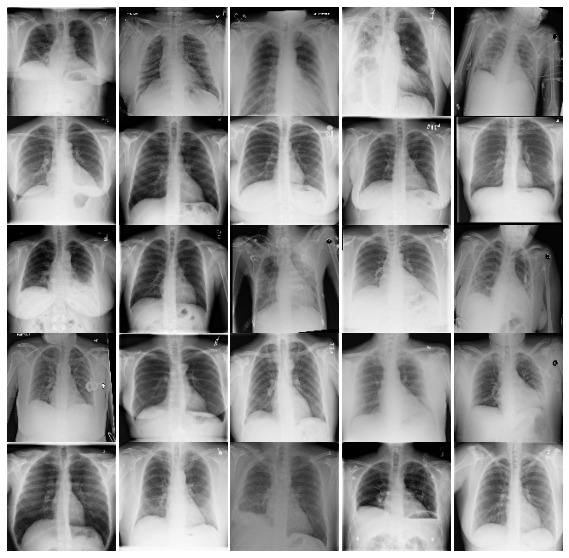

In [ ]:
multipleImages = glob('/gdrive/My Drive/multi_class/sample/sample/images/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

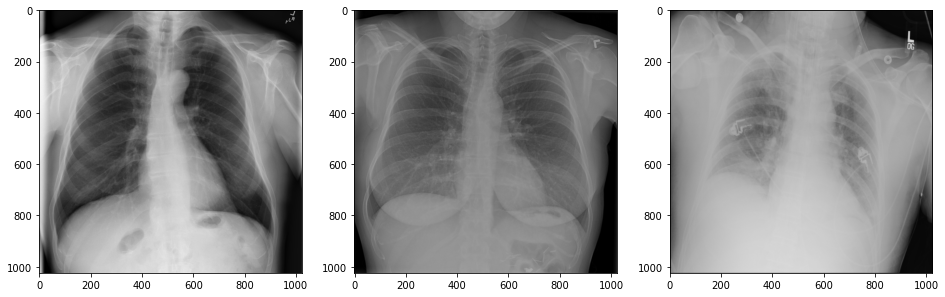

In [ ]:
r = random.sample(images, 3)
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(cv2.imread(r[0]))
plt.subplot(132)
plt.imshow(cv2.imread(r[1]))
plt.subplot(133)
plt.imshow(cv2.imread(r[2])); 

In [ ]:
labels = pd.read_csv('/gdrive/My Drive/multi_class/sample/sample_labels.csv')
labels.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,0.168
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,0.139
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139,0.139


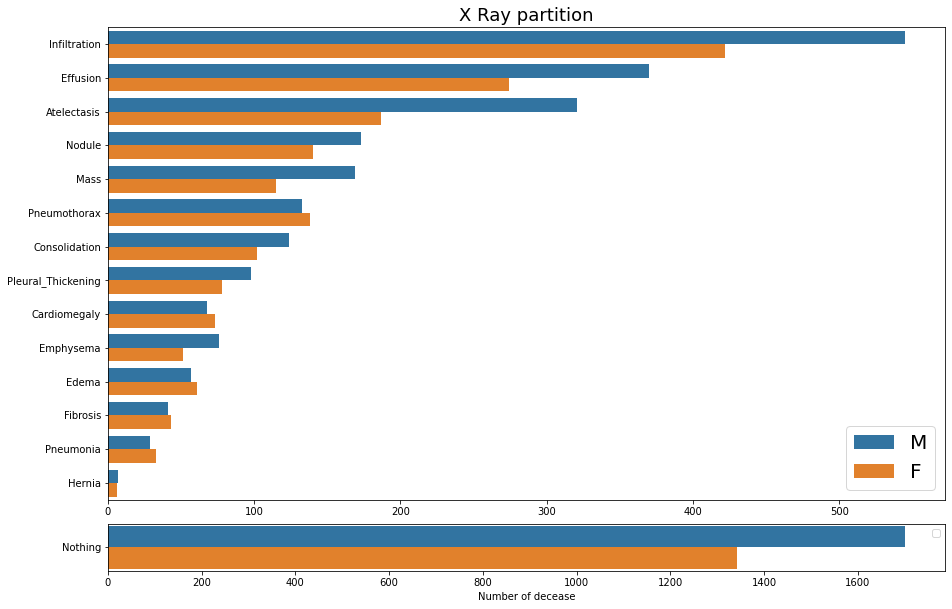

In [ ]:
#drop unused columns
labels = labels[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]
#create new columns for each decease
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
for pathology in pathology_list :
    labels[pathology] = labels['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
#remove Y after age
labels['Age']=labels['Patient Age'].apply(lambda x: x[:-1]).astype(int)

plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(labels,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition',fontsize=18);

labels['Nothing']=labels['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(labels,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

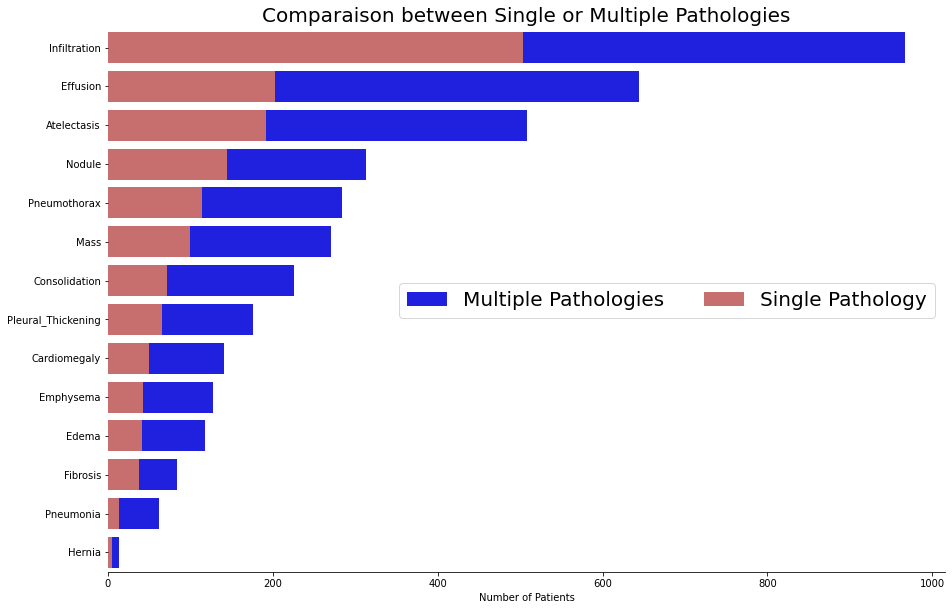

In [ ]:
df=labels
data=df.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=data[['|' in index for index in data.index]].copy()
df2=data[['|' not in index for index in data.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values

f, ax = plt.subplots(sharex=True,figsize=(15, 10))
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="r",label="Single Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=20)
ax.set( ylabel="",xlabel="Number of Patients")
ax.set_title("Comparaison between Single or Multiple Pathologies",fontsize=20)      
sns.despine(left=True)

In [ ]:
df=labels
data=df.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=data[['|' in index for index in data.index]].copy()
df2=data[['|' not in index for index in data.index]]

In [ ]:
def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    NoFinding = "No Finding" #0
    Consolidation="Consolidation" #1
    Infiltration="Infiltration" #2
    Pneumothorax="Pneumothorax" #3
    Edema="Edema" # 7
    Emphysema="Emphysema" #7
    Fibrosis="Fibrosis" #7
    Effusion="Effusion" #4
    Pneumonia="Pneumonia" #7
    Pleural_Thickening="Pleural_Thickening" #7
    Cardiomegaly="Cardiomegaly" #7
    NoduleMass="Nodule" #5
    Hernia="Hernia" #7
    Atelectasis="Atelectasis"  #6 
    RareClass = ["Edema", "Emphysema", "Fibrosis", "Pneumonia", "Pleural_Thickening", "Cardiomegaly","Hernia"]
    x = [] # images as arrays
    y = [] # labels
    WIDTH = 299
    HEIGHT = 299
    for img in images[0:100]:
        base = os.path.basename(img)
        # Read and resize image
        full_size_image = cv2.imread(img)
        finding = labels["Finding Labels"][labels["Image Index"] == base].values[0]
        symbol = "|"
        if symbol in finding:
            continue
        else:
            if NoFinding in finding:
                finding = 0
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))      
            elif Consolidation in finding:
                finding = 1
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Infiltration in finding:
                finding = 2
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Pneumothorax in finding:
                finding = 3
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Edema in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Emphysema in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Fibrosis in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Effusion in finding:
                finding = 4
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Pneumonia in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Pleural_Thickening in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Cardiomegaly in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif NoduleMass in finding:
                finding = 5
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Hernia in finding:
                finding = 7
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            elif Atelectasis in finding:
                finding = 6
                y.append(finding)
                x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
            else:
                continue
    return x,y

In [ ]:
X,y = proc_images()
df = pd.DataFrame()
df["images"]=X
df["labels"]=y
print(len(df), df.images[0].shape)
print(len(X))

78 (299, 299, 3)
78


In [ ]:
dict_characters = {0:'No finding' , 1: 'Consolidation', 2: 'Infiltration', 
        3: 'Pneumothorax', 4:'Effusion', 5: 'Nodule Mass', 6: 'Atelectasis', 7: "Other Rare Classes"}

print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       0
1  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       0
2  [[[42, 42, 42], [26, 26, 26], [19, 19, 19], [1...       2
3  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...       0
4  [[[20, 20, 20], [19, 19, 19], [20, 20, 20], [1...       4
5  [[[2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], ...       0
6  [[[24, 24, 24], [22, 22, 22], [22, 22, 22], [2...       0
7  [[[204, 204, 204], [197, 197, 197], [194, 194,...       0
8  [[[192, 192, 192], [152, 152, 152], [97, 97, 9...       0
9  [[[44, 44, 44], [34, 34, 34], [25, 25, 25], [1...       0

{0: 'No finding', 1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Effusion', 5: 'Nodule Mass', 6: 'Atelectasis', 7: 'Other Rare Classes'}


In [ ]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('Representative Image')
    b = cv2.resize(a, (512,512))
    plt.imshow(b)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
#plotHistogram(X[1])

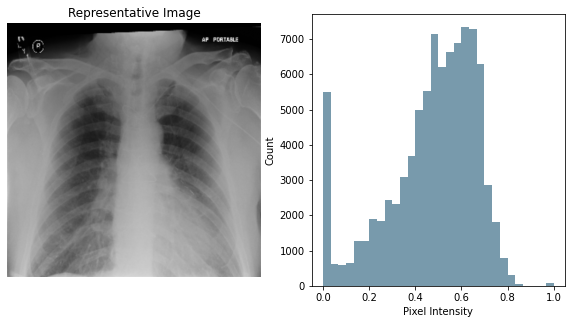

In [ ]:
X=np.array(X)
X=X/255.0
plotHistogram(X[1])

{0: 'No finding', 1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Effusion', 5: 'Nodule Mass', 6: 'Atelectasis', 7: 'Other Rare Classes'}


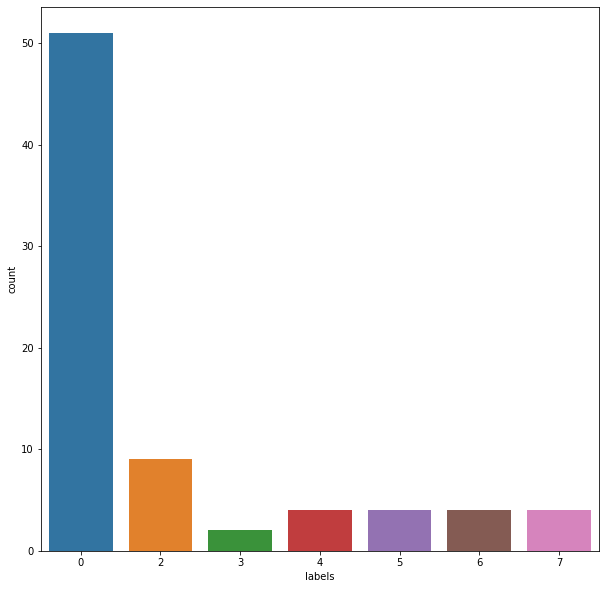

In [ ]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)
#print(dist)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train[0:5000] 
Y_train = Y_train[0:5000]
X_test = X_test[0:2000] 
Y_test = Y_test[0:2000]


In [ ]:
# print("Training Data Shape:", X_train.shape)
# print("Testing Data Shape:", X_test.shape)
print("Training Data Shape:", len(X_train), X_train[0].shape)
print("Testing Data Shape:", len(X_test), X_test[0].shape)

Training Data Shape: 62 (299, 299, 3)
Testing Data Shape: 16 (299, 299, 3)


In [ ]:

Y_trainHot = to_categorical(Y_train, num_classes = 8)
Y_testHot = to_categorical(Y_test, num_classes = 8)

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print(class_weight)

[0.21848739 1.23809524 5.57142857 2.78571429 2.78571429 2.78571429
 2.78571429]


In [ ]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [ ]:
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
print("X_train Shape: ",X_train.shape)
print("X_test Shape: ",X_test.shape)
print("X_trainFlat Shape: ",X_trainFlat.shape)
print("X_testFlat Shape: ",X_testFlat.shape)

X_train Shape:  (62, 299, 299, 3)
X_test Shape:  (16, 299, 299, 3)
X_trainFlat Shape:  (62, 268203)
X_testFlat Shape:  (16, 268203)


In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 8)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 8)
print("X_train: ", X_train.shape)
print("X_trainFlat: ", X_trainFlat.shape)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_testRos Shape: ",X_testRos.shape)
print("Y_trainRosHot Shape: ",Y_trainRosHot.shape)
print("Y_testRosHot Shape: ",Y_testRosHot.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


X_train:  (62, 299, 299, 3)
X_trainFlat:  (62, 268203)
X_trainRos Shape:  (234, 268203)
X_testRos Shape:  (48, 268203)
Y_trainRosHot Shape:  (234, 8)
Y_testRosHot Shape:  (48, 8)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
for i in range(len(X_trainRos)):
    height, width, channels = 299,299,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
print("X_trainRos Shape: ",X_trainRos.shape)
print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 299,299,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
print("X_testRos Shape: ",X_testRos.shape)
print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

X_trainRos Shape:  (234, 268203)
X_trainRosReshaped Shape:  (234, 299, 299, 3)
X_testRos Shape:  (48, 268203)
X_testRosReshaped Shape:  (48, 299, 299, 3)


{0: 'No finding', 1: 'Consolidation', 2: 'Infiltration', 3: 'Pneumothorax', 4: 'Effusion', 5: 'Nodule Mass', 6: 'Atelectasis', 7: 'Other Rare Classes'}


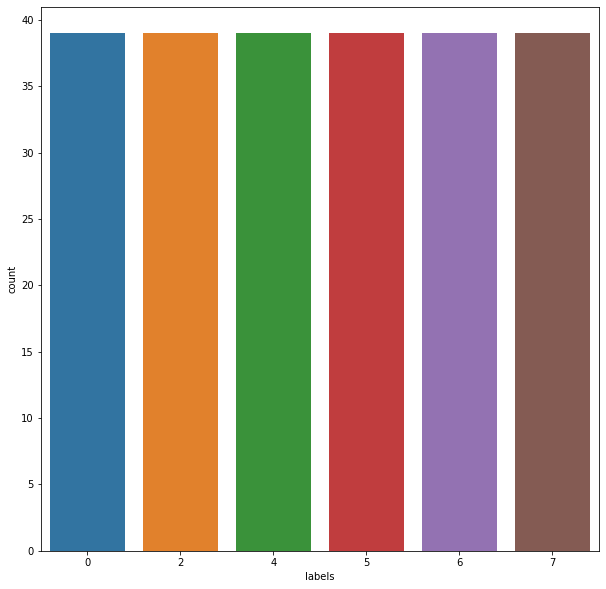

In [ ]:
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

In [ ]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight)

Old Class Weights:  [0.21848739 1.23809524 5.57142857 2.78571429 2.78571429 2.78571429
 2.78571429]
New Class Weights:  [1. 1. 1. 1. 1. 1.]


In [ ]:
#vgg16network(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:3000], Y_testRosHot[:3000],class_weight,8,15)

In [ ]:

# model = Sequential()
# model=(resnet.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000))
# model.summary()
# l=len(model.layers)
# #model=Model(inputs=model.input,outputs=model.get_layer("",l-1).output)
# for layer in model.layers[0:l]:
#   layer.trainable=True


base_model = Xception(include_top = False, weights = None)
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))




model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# h=2
# x=model.output
#model.summary()
# x=Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu')(x)
# x=Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu')(x)
# x=MaxPool2D(pool_size=(2,2))(x)
# x=BatchNormalization()(x)
# x=Dropout(0.25)(x)
# x=Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu')(x)
# x=Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu')(x)
# x=MaxPool2D(pool_size=(2,2))(x)
# x=BatchNormalization()(x)
# x=Dropout(0.25)(x)

# x=Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same',activation ='relu')(x)
# x=Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same',activation ='relu')(x)
# x=MaxPool2D(pool_size=(2,2))(x)
# x=BatchNormalization()(x)
# x=Dropout(0.25)(x)



# # x=Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu')(x)
# # x=Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu')(x)
# # #x=MaxPool2D(pool_size=(2,2))(x)
# # x=BatchNormalization()(x)
# # x=Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu')(x)
# # x=Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu')(x)
# # #x=MaxPool2D(pool_size=(2,2))(x)
# # x=BatchNormalization()(x)


# x=Flatten()(x)
# x=Dense(1024, activation = "relu")(x)
# # x=Dropout(0.5)(x)
# #x=Dense(512, activation = "relu")(x)
# # x=Dropout(0.5)(x)
# #x=Dense(256, activation = "relu")(x)
# # x=Dropout(0.5)(x)
# # x=Dense(128, activation = "relu")(x)
# # x=Dropout(0.5)(x)
# # x=Dense(64, activation = "relu")(x)
# x=Dropout(0.5)(x)

checkpoint_path='/gdrive/My Drive/checkpoint'

cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=2)

a=X_trainRosReshaped[:10000]
b=Y_trainRosHot[:10000]
c=X_testRosReshaped[:3000]
d=Y_testRosHot[:3000]
e=class_weight
f=8
g=15
epochs=g

history = model.fit(X_trainRosReshaped,Y_trainRosHot,batch_size=32, epochs=6, class_weight=e, validation_data=(c,d), verbose=1,callbacks = [cp_callback ])

score = model.evaluate(c,d, verbose=0)
print('\nKeras CNN #2 - accuracy:', score[1], '\n')
y_pred = model.predict(c)
#print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(d,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
#plot_learning_curve(history)
plt.show()
plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
   


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 4104      
Total params: 21,914,672
Trainable params: 21,860,144
Non-trainable params: 54,528
_____________________________________

NameError: ignored

In [ ]:
path='/gdrive/My Drive/train1'
model.save_weights(path,overwrite=True)
